In [141]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
### Imports
import os
import sys

import numpy as np
import pandas as pd

import pickle
import cv2

from pathlib import Path
from tensorflow.keras.models import Model

# import supported models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from tensorflow.compat.v1.keras.models import load_model
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import Adam

In [143]:
# get project path, and flag if script runs in a file
project_path = Path(os.getcwd(), os.pardir)
output_path = project_path / "output"

# add project root to pythonpath
sys.path.insert(0, str(project_path / "src"))

# import custom packages
from utils.identify import *   
from utils.findsets import *   
from set_cardgame.dataset import *

In [33]:
# name of first layer that had 100% validation score  
layer_name = "res3d_branch2a"
intermediate_model = load_model(
    output_path / f"resnet_{layer_name}_intermediate_model.h5",
    custom_objects=None,
    compile=True
)

### load model

In [34]:
nr_images = 8100
layer_name = "res3d_branch2a"

with open(output_path / f'clf_{layer_name}_{nr_images}.pkl', 'rb') as handle:
    best_model = pickle.load(handle)

In [35]:
# load training and validation data
X_test, y_test, X_val, y_val = load_dataset(nr_images=810, output_path=None, preprocessing_func=preprocess_input_resnet50)
print("X_test.shape:", X_test.shape)

Found 243 images belonging to 81 classes.
Found 81 images belonging to 81 classes.
X_test.shape: (810, 96, 128, 3)


In [245]:
# generate image embeddings
X_test_embeddings = intermediate_model.predict(X_test).reshape(X_test.shape[0], -1)

In [246]:
test_score = best_model.score(X_test_embeddings, y_test)
print(f"test_score:{test_score}")

test_score:1.0


In [247]:
df_meta = load_metadata()

### Detect SET combinations

In [275]:
def to_rgb3(im):
    # we can use dstack and an array copy
    # this has to be slow, we create an array with
    # 3x the data we need and truncate afterwards
    return np.asarray(np.dstack((im, im, im)), dtype=np.uint8)


def get_mask(img, bboxes):
    # draw filled contours
    img_bg = cv2.drawContours(img, bboxes, -1, (255, 255, 255), -1)

    # convert to grayscale
    img_bg = cv2.cvtColor(img_bg, cv2.COLOR_BGR2GRAY)

    # threshold
    flag, thresh = cv2.threshold(img_bg, 250, 255, cv2.THRESH_BINARY)

    return thresh


def plot_sets(img, image_name, bboxes, sets, line_color=(255, 22, 84), line_width=20, save=True):
    set_images = []
    
    img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    
    for i, s in enumerate(sets, start=1):
        # mask for alpha blending
        img_mask = get_mask(img.copy(), bboxes[s])

        # foreground with contours
        img_contours = cv2.drawContours(img.copy(), bboxes[s], -1, line_color, line_width)
        
        # dark version of contours
        foreground = img_contours.copy().astype(float) / 255
        background = 0.5*(img_contours.copy() / 255)
                
        alpha = to_rgb3(img_mask).astype(float)/255
        
        # Multiply the foreground with the alpha
        foreground = cv2.multiply(alpha, foreground)

        # Multiply the background with ( 1 - alpha )
        background = cv2.multiply(1.0 - alpha, background)
        
        # Add the masked foreground and background.
        outImage = cv2.add(foreground, background)
        
        outImage = (outImage*255).astype(int)
        
        if save == True:
            cv2.imwrite(str(output_path / f"{image_name}_set{i}.png"), outImage)
        set_images.append(outImage)
    return set_images

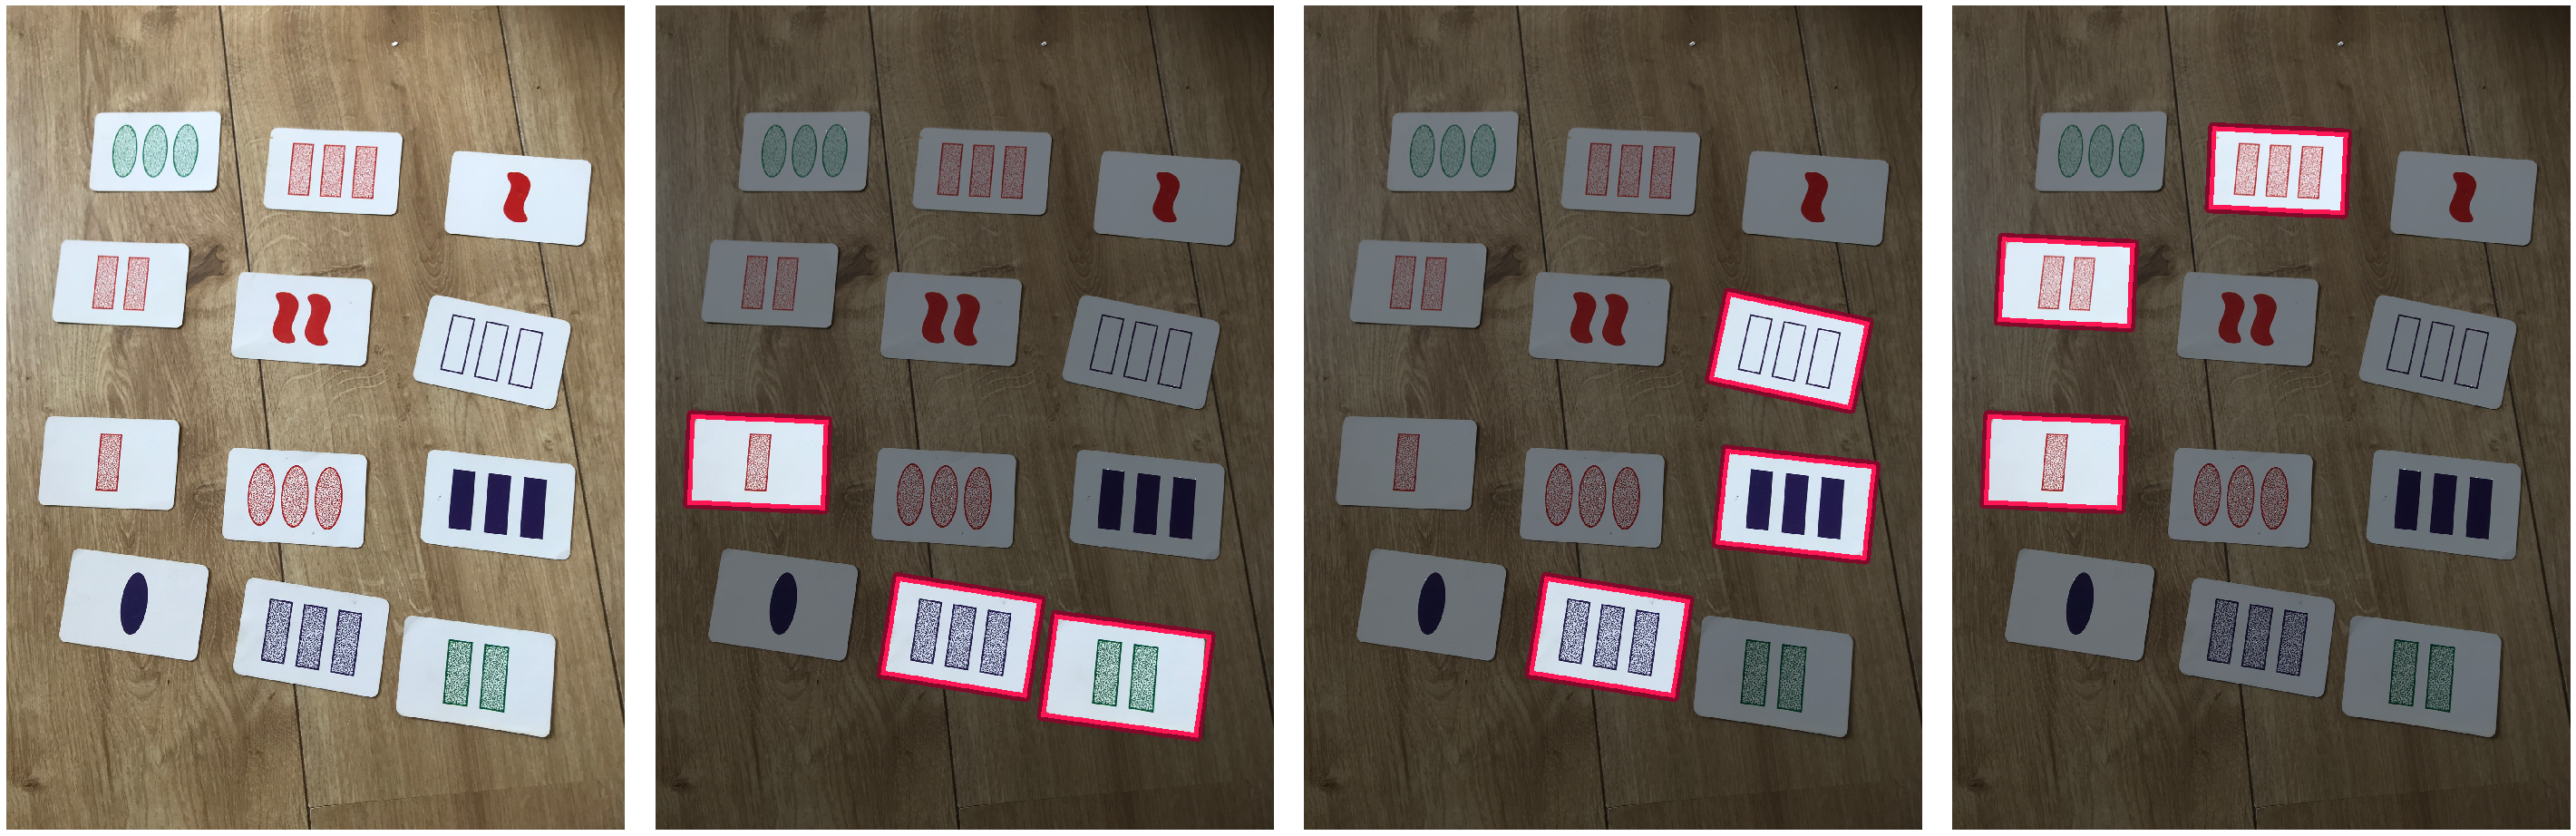

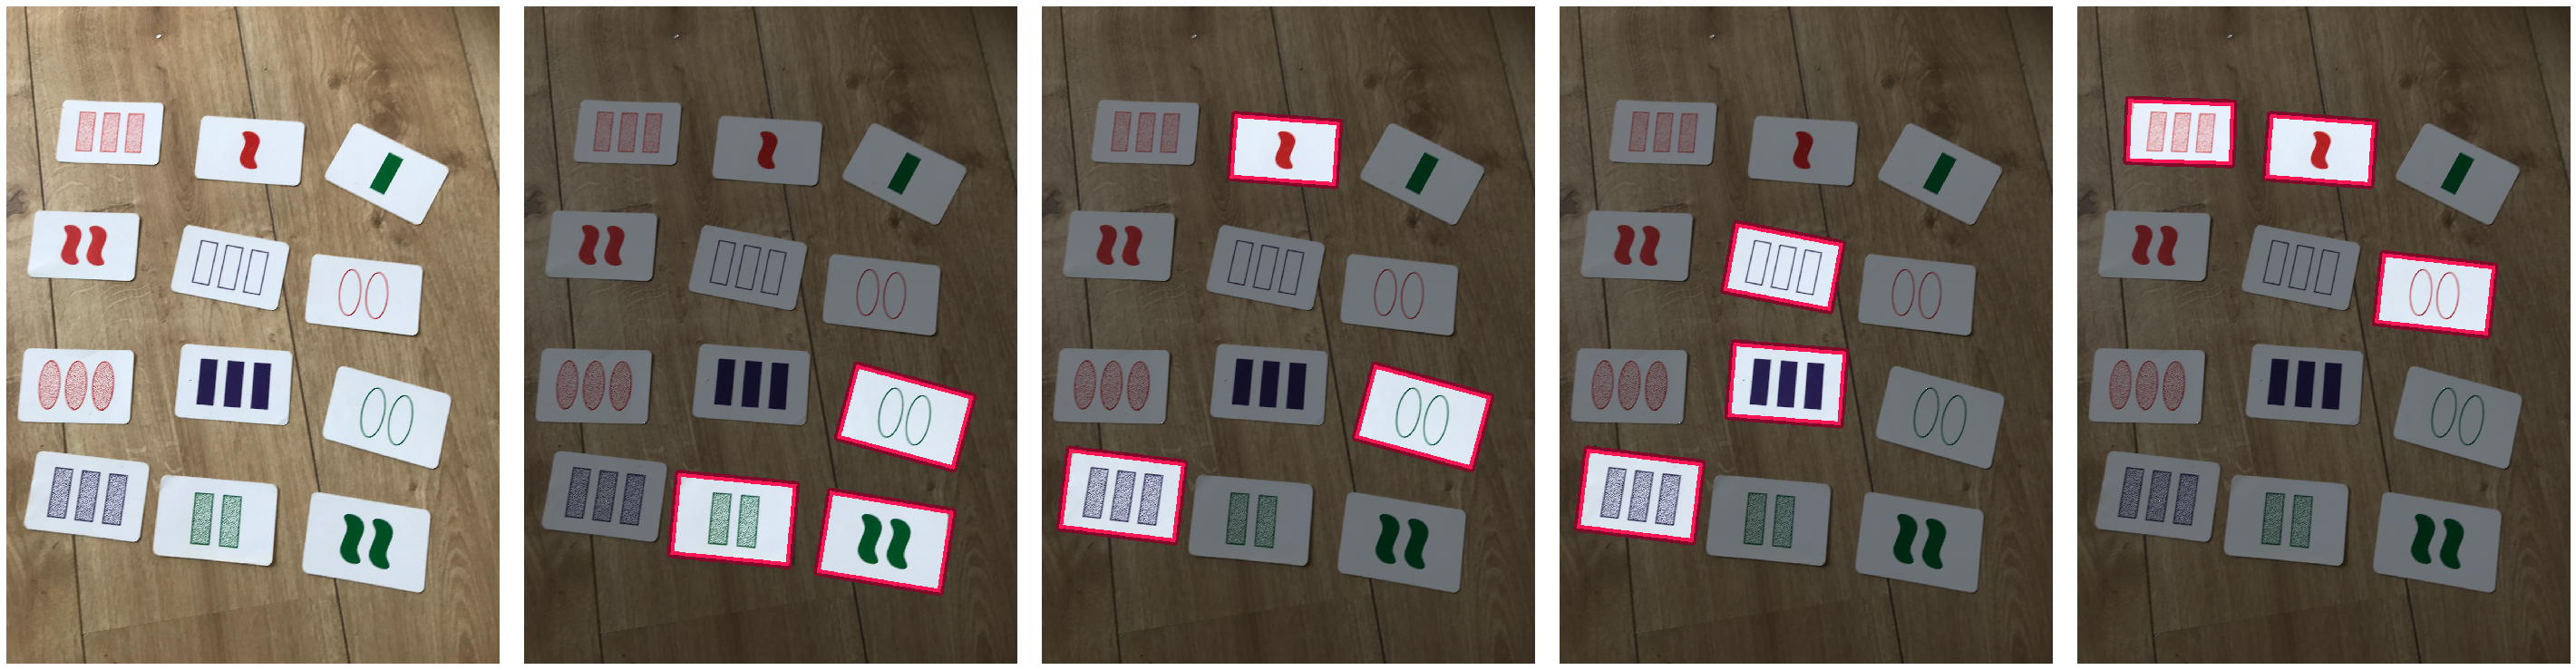

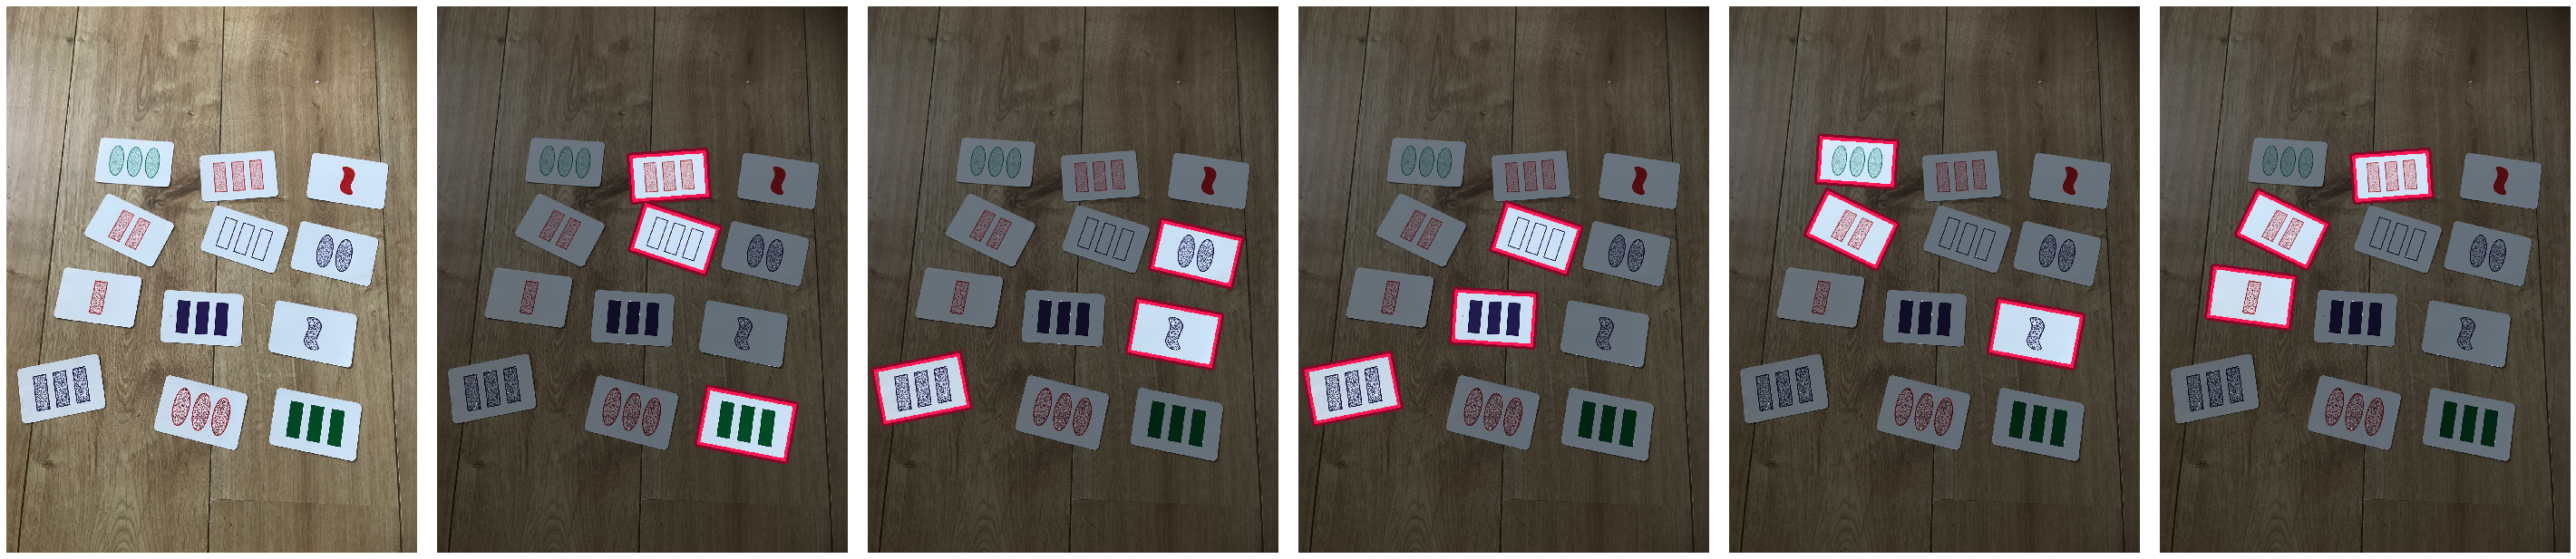

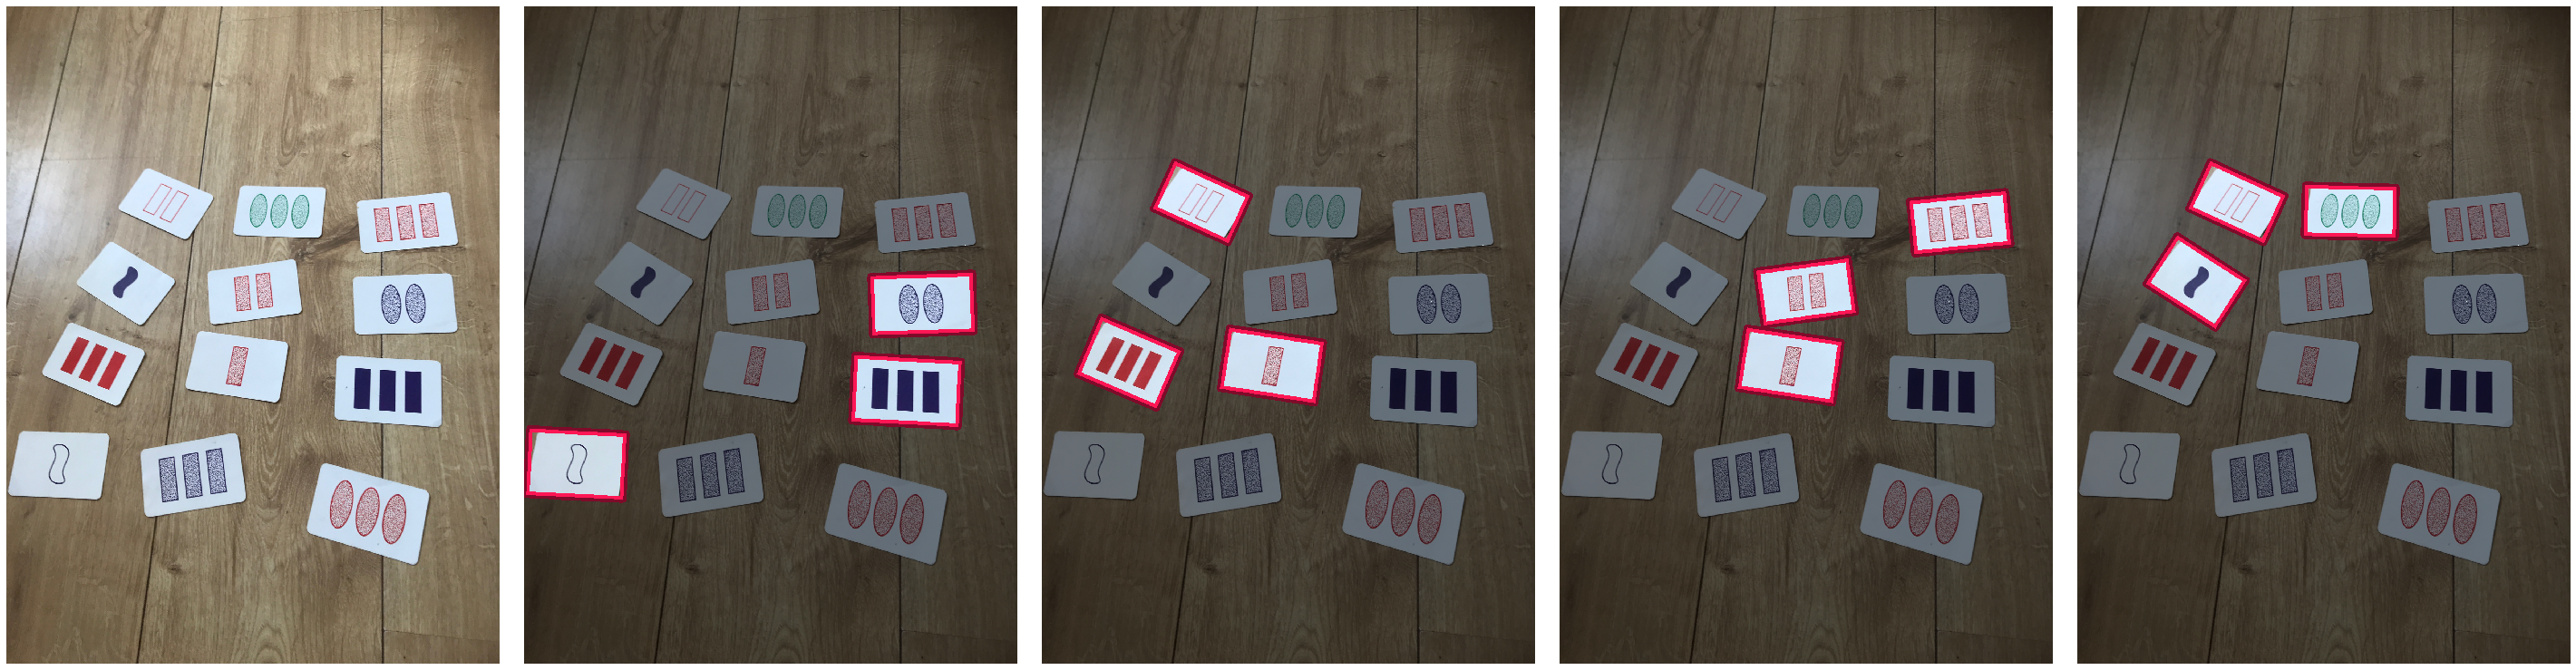

In [276]:
# putting it all together
test_images_path = project_path / "test_images"

#X_identify = np.array([])
target_width = 128
target_height = 96
for image_name in os.listdir(test_images_path):
        
    # read image
    img = cv2.imread(str(test_images_path / image_name))
    
    # identify the different cards
    identified_images, bboxes = identify_images(img, target_size=(target_width, target_height))
    
    # generate image embeddings for each card
    image_embeddings = intermediate_model.predict(identified_images).reshape(identified_images.shape[0], -1)
    #print(f'image_embeddings.shape: {image_embeddings.shape}')
    
    # classify cards
    predictions = best_model.predict(image_embeddings)

    # get feature codes for each prediction
    predictions_features = get_feature_codes(df_meta, predictions)
    
    # find all sets
    sets = findsets(predictions_features)
    
    # plot sets
    set_images = plot_sets(img, image_name, bboxes, sets, save=True)
    
    nr_sets_found = len(set_images)
    
    # convert to rgb for plotting
    img_rgb = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    
    set_images = [img_rgb] + set_images
    
    fig, axs = plt.subplots(nrows=1, ncols=nr_sets_found+1, figsize=(40, 20))
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.05)
    for i, set_image in enumerate(set_images):
        axs[i].imshow(set_image)
        axs[i].axis('off')
    plt.savefig(output_path / f"found_sets_{image_name}.png", bbox_inches='tight')
    plt.show()

### read from camera

In [12]:
cap = cv2.VideoCapture(0)

while(1):
    ret, frame = cap.read()
    
    cv2.imshow('Camera', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()

cv2.destroyAllWindows()